# Collaboration and competition

---

## 1. Introduction

In this notebook, we solve a prebuilt `Tennis`environment from the [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) engine. Our agents learn to play using a vanilla implementation of the `Multi-Agent Deep Deterministic Policy Gradients` (MADDPG) algorithm.

In [1]:
# Imports
from unityagents import UnityEnvironment
import numpy as np

## 2. Description of the environment and example run

The simulation contains two agents, two tennis rackets that can move forward and backwards, as well as jump. The environment also contains a ball that moves in the court, and which the agents will try to bounce over the net. The environment is better described as follows:

- **State space**: The state space dimension `8` for each agent. These 8 dimensions represent position and velocity (in `x`, `y`) coordinates for both the agent and the ball. The state representation available in the environment contains 3 stacked state vectors, in order to provide info on the actual progression of the ball. Each agent only have access to their own (local) state observations.


- **Action space**: Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.


- **Rewards**: If an agent hits the ball over the net, it receives a reward of `+0.1`. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of `-0.01`. Thus, the goal of each agent is to keep the ball in play.


- **Episodes**: The task is episodic and the reward is measured as the maximum total reward recieved by any of the agents. The environment is considered solved when a mean score of `+0.5` is achieved over `100` consecutive episodes.

---

### 2.1. Exploring the environment

We explore the environment in the code below

In [2]:
##########################
#### THE ENVIRONMENT #####
##########################

# Initialize the environment and get the default brain
env = UnityEnvironment(file_name="Tennis_Windows_x86_64//Tennis.x86_64")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

num_agents = len(env_info.agents)
print('Number of agents:', num_agents)


##########################
#### THE STATE SPACE #####
##########################

state = env_info.vector_observations[0]
print('Total dimensions in state:', len(state))
print('States look like:', state)


######################
## THE ACTION SPACE ##
######################

action_size = brain.vector_action_space_size
print('Action space dimension:', action_size)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Total dimensions in state: 24
States look like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
Action space dimension: 2


### 2.2. Example run

Let's see how a random agent would perform

In [3]:
# Play 5 episodes
for i in range(5):
    
    # Reset the environment, get current state for each agent and initialize scores
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations
    scores = np.zeros(num_agents)
    dones = [False, False]
    
    # Play the episode
    while not np.any(dones):
        
        # Select an action (for each agent) and clip them between -1 and 1
        actions = np.random.randn(num_agents, action_size) 
        actions = np.clip(actions, -1, 1)
        
        # Execute the actions
        env_info = env.step(actions)[brain_name]   
        
        # Get next states, rewards, and info on whether the episode is over
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        
        # Update total scores and assign next states as the new states
        scores += env_info.rewards
        states = next_states
        
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
env.close()


Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.09500000160187483
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


## 3. Training an agent (restart the kernel before running)

Initialize the environment:

In [1]:
# Imports
from unityagents import UnityEnvironment
import numpy as np
from DDPG import *
from collections import deque
import torch
import matplotlib.pyplot as plt

# Initialize the environment and assign the brain
env = UnityEnvironment(file_name="Tennis_Windows_x86_64//Tennis.x86_64")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Reset environment and assign initial state
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations[0]
num_agents = len(env_info.agents)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Initialize the two agents:

In [2]:
agents = [Agent(agent_index = 1,
                state_size = len(state),
                action_size = brain.vector_action_space_size, 
                seed = 42),
          Agent(agent_index = 2,
                state_size = len(state),
                action_size = brain.vector_action_space_size, 
                seed = 42)]


Main algorithm and evolution of scores after training:

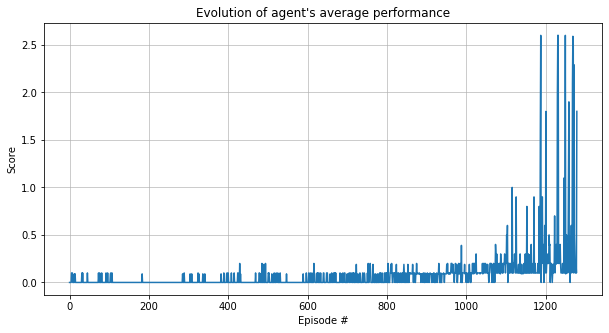

In [4]:
n_episodes=25000
eps_start=0.6
eps_end=0.0005 
eps_decay=0.9975


''' Train a Deep Deterministic Policy Gradient agent to solve the environment '''

scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
eps = eps_start                    # initialize epsilon

# For each one of the training episodes
for i_episode in range(1, n_episodes+1):

    # Restart the environment and the score
    env_info = env.reset(train_mode=True)[brain_name]
    running_scores = [0, 0]

    # Get agent's current states (two-element lists with local observations)
    states = env_info.vector_observations
    dones = [False, False]

    # Play the episode
    while not np.any(dones):

        # Get the noise-greedy actions for each agent
        actions = [agent.act(states[i], eps).data.numpy() for i, agent in enumerate(agents)]

        # Take the action and store environment output
        env_info = env.step(actions)[brain_name] 
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done

        # Update agent's knowledge
        for agent_index, agent in enumerate(agents): 
            agent.step(agent_index, states, actions, rewards, next_states, dones)
            running_scores[agent_index] += rewards[agent_index]

        # Move onto next state
        states = next_states

    # When the episode is done, save scores into our lists, and decrease the epsilon for the next episode
    scores_window.append(np.max(running_scores))
    scores.append(np.max(running_scores))              
    eps = max(eps_end, eps_decay*eps)

    if i_episode % 20 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

    # When the agent is trained, we save the weights of the Q-network and exit the routine
    if np.mean(scores_window)>=0.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
        break

for i, agent in enumerate(agents): torch.save(agent.actor_local.state_dict(), 'trained_agent_{}.pth'.format(i))

    
# Evolution of scores
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title("Evolution of agent's average performance")
plt.grid(alpha=0.8)
plt.show()

## 4. Our agent in action! (restart the kernel before running)

We leverage the network weights learned in section 3 to create an intelligent agent, and watch it interact with its environment.

In [1]:
# Imports
from unityagents import UnityEnvironment
import numpy as np
from DDPG import *
from collections import deque
import torch

# Initialize the environment and assign the brain
env = UnityEnvironment(file_name="Tennis_Windows_x86_64//Tennis.x86_64")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name] 
states = env_info.vector_observations  
num_agents = len(env_info.agents)

# Start an agent and assign it the trained network
agents = [Agent(agent_index = 1,
                state_size = len(states[0]),
                action_size = brain.vector_action_space_size, 
                seed = 42),
          Agent(agent_index = 2,
                state_size = len(states[0]),
                action_size = brain.vector_action_space_size, 
                seed = 42)]

for i, agent in enumerate(agents): agent.actor_local.load_state_dict(torch.load('trained_agent_{}.pth'.format(i)))

    
for i_episode in range(10):
    
    # Reset the environment, assign the initial state and initialize the score
    env_info = env.reset(train_mode=False)[brain_name] 
    states = env_info.vector_observations  
    num_agents = len(env_info.agents)
    dones = [False, False]
    scores = np.zeros(num_agents)
    while not np.any(dones):

        # Get the noise-greedy actions for each agent
        actions = [agent.act(states[i]).data.numpy() for i, agent in enumerate(agents)]

        # Take the action and store environment output
        env_info = env.step(actions)[brain_name] 
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done

        # Update agent's knowledge
        for i, agent in enumerate(agents): scores[i] += rewards[i]

        # Move onto next state
        states = next_states

#print("Final score: {}".format(score))
env.close() 
    

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 
